In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
df = pd.read_csv('est_19.csv')

In [8]:
import pandas as pd
import numpy as np
import re
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class LimpiezaDatosMicroclimas:
    """
    Versión robusta de limpieza:
    - Normaliza strings (quita unidades y símbolos)
    - Combina fecha+hora con pandas.to_datetime (múltiples formatos)
    - Convierte columnas numéricas limpiando comas/espacios
    - Interpola en base a índice datetime (NO usa estacion_sk)
    - Maneja booleanas y categorias
    """

    def __init__(self, archivo_csv):
        self.df = pd.read_csv(archivo_csv, dtype=str)  # leer todo como str para limpieza controlada
        self.df_original = self.df.copy()

        # Normalizar tokens vacíos a NaN (incluye guiones largos)
        self.df.replace(['', ' ', 'NA', 'N/A', 'null', 'Null', 'NULL', '--', '—', 'na'],
                        np.nan, inplace=True)

        # no usar estacion_sk
        if 'estacion_sk' in self.df.columns:
            self.df.drop(columns=['estacion_sk'], inplace=True)

        # Rangos recomendados)
        self.rangos_climaticos = {
            'temperatura': {'min': -10, 'max': 40},
            'humedad': {'min': 0, 'max': 100},
            'presion': {'min': 600, 'max': 620},  # mmHg
            'velocidad': {'min': 0, 'max': 100},
            'precipitacion': {'min': 0, 'max': 1000},
            'precipitacion_real': {'min': 0, 'max': 1000},
            'radiacion': {'min': 0, 'max': 2000},
            'evapotranspiracion': {'min': 0, 'max': 100},
            'evapo_real': {'min': 0, 'max': 100},
            'caudal': {'min': 0, 'max': 1e6},
            'nivel': {'min': 0, 'max': 1e6},
        }

        self.reporte = {
            'filas_originales': len(self.df),
            'duplicados_eliminados': 0,
            'valores_imputados': {},
            'outliers_detectados': {},
            'errores_datetime': 0
        }


    # Helpers de limpieza

    @staticmethod
    def _limpiar_numero_str(s):
        """
        Limpia una cadena para extraer el primer número válido.
        Reemplaza comas por puntos, elimina unidades y caracteres no numéricos
        manteniendo '.' y '-' (decimal/negativo).
        Devuelve float o np.nan.
        """
        if pd.isna(s):
            return np.nan
        s = str(s).strip()
        # Reemplazar coma decimal
        # Primero quitar espacios dentro del número
        s = s.replace('\xa0', '').replace(' ', '')
        # Reemplazar coma por punto cuando hay coma seguida de dígitos (e.g., "15,6")
        s = re.sub(r'(?<=\d),(?=\d)', '.', s)
        # Extraer el primer match de número con decimal o entero (incluye signo)
        m = re.search(r'[-+]?\d*\.\d+|[-+]?\d+', s)
        if m:
            try:
                return float(m.group(0))
            except:
                return np.nan
        return np.nan


    # 1. Crear datetime robusto

    def combinar_fecha_hora(self):
        # Algunos valores pueden venir ya en datetime en 'fecha' o 'hora'
        # Intenta concatenar y usar pd.to_datetime con dayfirst True
        df = self.df.copy()
        # Preparar strings
        df['fecha'] = df['fecha'].astype(str).str.strip().replace('nan', np.nan)
        df['hora'] = df['hora'].astype(str).str.strip().replace('nan', np.nan)

        # Concatenar cuando ambas existan
        df['__fecha_hora'] = df.apply(
            lambda r: (r['fecha'] + ' ' + r['hora']) if pd.notna(r['fecha']) and pd.notna(r['hora']) else r['fecha'] if pd.notna(r['fecha']) else np.nan,
            axis=1
        )

        # Intentar parsear con distintos parámetros
        df['datetime'] = pd.to_datetime(df['__fecha_hora'], dayfirst=True, errors='coerce', infer_datetime_format=True)

        # Si quedaron NaT, intentar parseo alternativo
        mask_bad = df['datetime'].isna() & df['__fecha_hora'].notna()
        if mask_bad.any():
            df.loc[mask_bad, 'datetime'] = pd.to_datetime(df.loc[mask_bad, '__fecha_hora'], dayfirst=False, errors='coerce', infer_datetime_format=True)

        self.df['datetime'] = df['datetime']
        self.reporte['errores_datetime'] = int(self.df['datetime'].isna().sum())

        # Para interpolaciones temporales se necesita un índice datetime
        # Mantener copia de fecha/hora originales; no las eliminamos
        # Ordenar por datetime (NaT al final)
        self.df = self.df.sort_values('datetime').reset_index(drop=True)


    # 2. Normalizar cadenas y convertir numéricos

    def convertir_numericos(self):
        # Columnas numéricas
        columnas_posibles = [
            'temperatura', 'velocidad', 'direccion', 'presion', 'humedad',
            'precipitacion', 'precipitacion_real', 'radiacion',
            'evapotranspiracion', 'evapo_real', 'caudal', 'nivel'
        ]

        for col in columnas_posibles:
            if col in self.df.columns:
                # Aplica limpieza robusta string->float
                self.df[col] = self.df[col].apply(self._limpiar_numero_str).astype(float)


    # 3. Booleanas seguras

    def convertir_booleanas(self):
        booleanas = ['puerta_Abierta', 'bateria_Baja', 'solar_energia', 'sensor_Activo']
        for col in booleanas:
            if col in self.df.columns:
                s = self.df[col].astype(str).str.strip().str.lower().replace('nan', np.nan)
                self.df[col] = s.map({
                    'true': True, '1': True, 'si': True, 'sí': True, 's': True,
                    'false': False, '0': False, 'no': False, 'n': False
                })
                # Si quedaron NaN, rellenar con False
                if self.df[col].isna().all():
                    # Si la columna está vacía, dejarla como False por defecto
                    self.df[col] = False
                else:
                    # imputar moda
                    try:
                        moda = self.df[col].mode().iloc[0]
                        self.df[col].fillna(moda, inplace=True)
                    except:
                        self.df[col].fillna(False, inplace=True)


    # 4. direccion_rosa como categoria

    def procesar_direccion_rosa(self):
        if 'direccion_rosa' in self.df.columns:
            self.df['direccion_rosa'] = self.df['direccion_rosa'].astype(str).str.strip().replace('nan', np.nan)
            # Normalizar a mayúsculas cortas (N, S, E, O, NE, etc.)
            self.df['direccion_rosa'] = self.df['direccion_rosa'].str.upper()
            self.df['direccion_rosa'].replace('', np.nan, inplace=True)
            # Si mucha falta, dejar NaN; imputamos moda más tarde si necesario
            try:
                # convertir a category (sin forzar)
                self.df['direccion_rosa'] = self.df['direccion_rosa'].astype('category')
            except:
                pass


    # 5. Duplicados

    def eliminar_duplicados(self):
        antes = len(self.df)
        self.df.drop_duplicates(inplace=True)
        # También intentar duplicados por datetime + otras columnas
        if 'datetime' in self.df.columns:
            self.df.drop_duplicates(subset=['datetime'], inplace=True)
        despues = len(self.df)
        self.reporte['duplicados_eliminados'] = int(antes - despues)


    # 6. Detectar outliers por rango (opcional)

    def detectar_outliers_por_rango(self):
        for col, r in self.rangos_climaticos.items():
            if col in self.df.columns:
                mask = (self.df[col] < r['min']) | (self.df[col] > r['max'])
                n_out = int(mask.sum())
                self.reporte['outliers_detectados'][col] = n_out
                # solo marcar como NaN si hay sentido hacerlo
                if n_out > 0:
                    self.df.loc[mask, col] = np.nan


    # 7. Imputación (interpolación temporal)

    def imputar(self):
        # Usar valores en 'observaciones' si extraemos info (temperatura/humedad/precipitacion)
        if 'observaciones' in self.df.columns:
            # extraer numero en observaciones para temperatura/humedad/precipitación (similar a antes)
            def extraer_obs(s, key):
                if pd.isna(s):
                    return np.nan
                s = s.lower()
                patterns = {
                    'temperatura': r'temperatura[:\s]+([0-9]+\.?[0-9]*)',
                    'humedad': r'humedad[:\s]+([0-9]+\.?[0-9]*)',
                    'precipitacion': r'precipitaci[oó]n[:\s]+([0-9]+\.?[0-9]*)'
                }
                r = patterns.get(key)
                m = re.search(r, s) if r else None
                return float(m.group(1)) if m else np.nan

            for key in ['temperatura', 'humedad', 'precipitacion']:
                if key in self.df.columns:
                    obs_col = self.df['observaciones'].apply(lambda x: extraer_obs(x, key))
                    mask = self.df[key].isna() & obs_col.notna()
                    self.df.loc[mask, key] = obs_col[mask]

        # Interpolación temporal: requerimos índice datetime
        if 'datetime' in self.df.columns:
            df_time = self.df.set_index('datetime').sort_index()
            # interpolar por tiempo sobre todo el dataset
            numeric_cols = df_time.select_dtypes(include=[np.number]).columns.tolist()
            # usar method='time' si datetime index no es monotónico (pandas lo requiere)
            try:
                df_time[numeric_cols] = df_time[numeric_cols].interpolate(method='time', limit_direction='both')
            except Exception:
                # fallback a linear
                df_time[numeric_cols] = df_time[numeric_cols].interpolate(method='linear', limit_direction='both')

            # si quedaron NaN rellenar con mediana global
            for col in numeric_cols:
                if df_time[col].isna().sum() > 0:
                    med = df_time[col].median()
                    df_time[col].fillna(med, inplace=True)
                    self.reporte['valores_imputados'][col] = int(df_time[col].isna().sum())  # aproximado

            # Restaurar
            self.df = df_time.reset_index()

        else:
            # si no hay datetime, rellenar numéricos con mediana
            numericas = [c for c in self.df.columns if self.df[c].dtype in [np.float64, np.int64]]
            for col in numericas:
                n_before = self.df[col].isna().sum()
                if n_before > 0:
                    self.df[col].fillna(self.df[col].median(), inplace=True)
                    self.reporte['valores_imputados'][col] = int(n_before)

        # Imputar direccion_rosa con moda si falta
        if 'direccion_rosa' in self.df.columns:
            try:
                moda = self.df['direccion_rosa'].mode().iloc[0]
                self.df['direccion_rosa'].fillna(moda, inplace=True)
            except:
                pass

        # Booleanas ya convertidas; asegurar no NaN
        for b in ['puerta_Abierta', 'bateria_Baja', 'solar_energia', 'sensor_Activo']:
            if b in self.df.columns:
                if self.df[b].isna().sum() > 0:
                    moda = self.df[b].mode().iloc[0] if not self.df[b].mode().empty else False
                    self.df[b].fillna(moda, inplace=True)


    # 8. Limpieza final y reporte

    def limpiar_final(self):
        # Asegurar que tipos están bien
        # convertir small-int columns
        # No eliminar 'fecha'/'hora' para mantener trazabilidad
        pass

    def ejecutar(self):
        # Secuencia
        self.combinar_fecha_hora()
        self.convertir_numericos()
        self.convertir_booleanas()
        self.procesar_direccion_rosa()
        self.eliminar_duplicados()
        # detectar outliers basado en rangos ajustados
        self.detectar_outliers_por_rango()
        # imputar por tiempo
        self.imputar()
        self.limpiar_final()

        # resumen final: info y conteos NaN
        reporte_basico = {
            'info': self.df.info(),
            'nulos_por_columna': self.df.isna().sum().to_dict(),
            'reporte_interno': self.reporte
        }

        return self.df, reporte_basico

In [9]:
limpiador = LimpiezaDatosMicroclimas('est_19.csv')
df_limpio = limpiador.ejecutar()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 382392 entries, 0 to 382391
Data columns (total 21 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   datetime            382392 non-null  datetime64[ns]
 1   fecha               382392 non-null  object        
 2   hora                382392 non-null  object        
 3   temperatura         382392 non-null  float64       
 4   velocidad           382392 non-null  float64       
 5   direccion           382392 non-null  float64       
 6   direccion_rosa      382392 non-null  category      
 7   caudal              382392 non-null  float64       
 8   presion             382392 non-null  float64       
 9   humedad             382392 non-null  float64       
 10  precipitacion       382392 non-null  float64       
 11  precipitacion_real  382392 non-null  float64       
 12  radiacion           382392 non-null  float64       
 13  evapotranspiracion  382392 no

In [10]:
df_limpio[0].to_csv('est_19_limpio.csv', index=False)

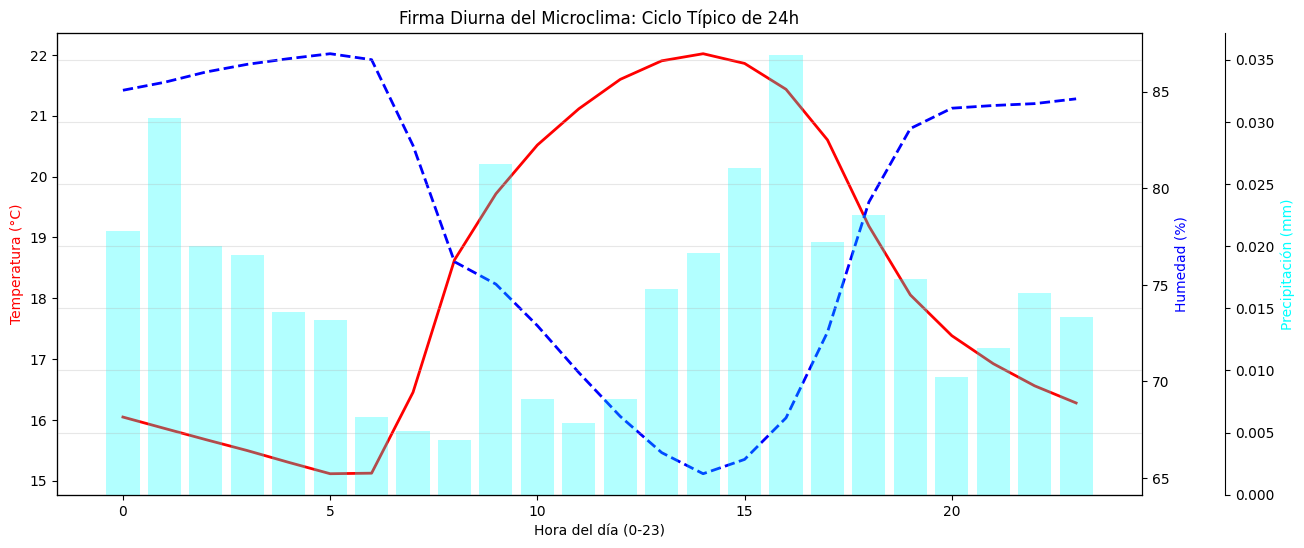

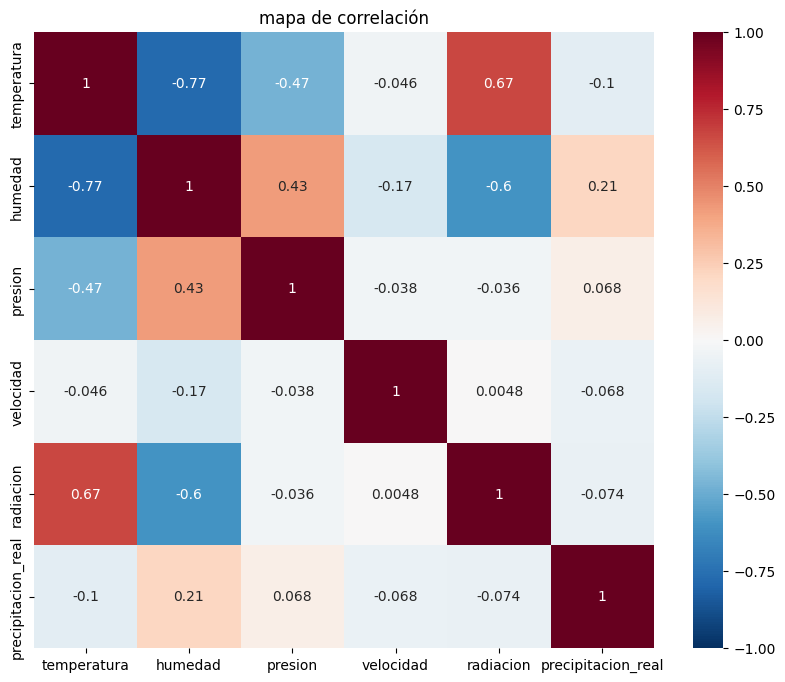

Usando columna numérica original 'direccion'


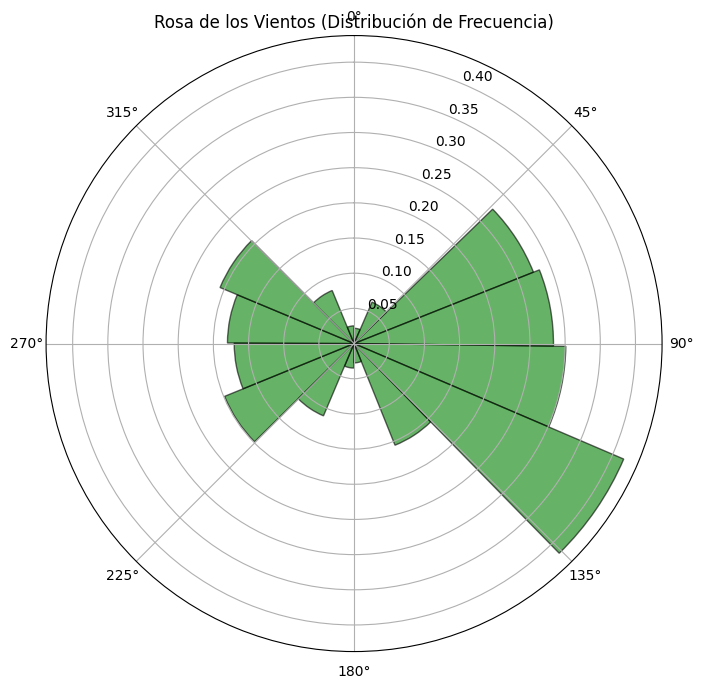

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# 1. PREPARACIÓN DEL DATAFRAME (Conectando con tu clase)

df_eda = df_limpio[0].copy() # Corrected: Access the DataFrame from the tuple

# Aseguramos que el índice sea datetime para las series de tiempo
if 'datetime' in df_eda.columns:
    df_eda = df_eda.set_index('datetime').sort_index()

# Filtramos solo columnas físicas útiles para el clima (excluimos batería, puerta, etc)
cols_fisicas = ['temperatura', 'humedad', 'presion', 'velocidad',
                'radiacion', 'precipitacion_real']

# Filtramos solo las que realmente existan en tu df
cols_plot = [c for c in cols_fisicas if c in df_eda.columns]
df_fisico = df_eda[cols_plot]


# 2. IDENTIFICACIÓN DE LA "FIRMA DEL MICROCLIMA" (Ciclo Diurno)

# Esto responde: ¿Cómo se comporta ESTA zona específica durante el día?
df_fisico['hora'] = df_fisico.index.hour
promedios_hora = df_fisico.groupby('hora').mean()
# Para lluvia usamos suma (o promedio, depende si quieres intensidad o probabilidad)
lluvia_hora = df_fisico.groupby('hora')['precipitacion_real'].mean()

plt.figure(figsize=(14, 6))

# Eje izquierdo: Temperatura y Humedad
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(promedios_hora.index, promedios_hora['temperatura'], 'r-', lw=2, label='Temperatura')
ax2.plot(promedios_hora.index, promedios_hora['humedad'], 'b--', lw=2, label='Humedad')

# Añadimos barras de lluvia de fondo
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60)) # Mover eje para que no se solape
ax3.bar(lluvia_hora.index, lluvia_hora.values, color='cyan', alpha=0.3, label='Precipitación')

ax1.set_ylabel('Temperatura (°C)', color='r')
ax2.set_ylabel('Humedad (%)', color='b')
ax3.set_ylabel('Precipitación (mm)', color='cyan')
ax1.set_xlabel('Hora del día (0-23)')
plt.title(f'Firma Diurna del Microclima: Ciclo Típico de 24h')
plt.grid(True, alpha=0.3)
plt.show()


# 3. MATRIZ DE CORRELACIÓN FÍSICA

plt.figure(figsize=(10, 8))
# Usamos Spearman porque las relaciones en clima no siempre son lineales
corr = df_fisico.drop(columns=['hora']).corr(method='spearman')
sns.heatmap(corr, annot=True, cmap='RdBu_r', vmin=-1, vmax=1)
plt.title('mapa de correlación')
plt.show()


# 4. ANÁLISIS DE VIENTO (CORREGIDO: Usando direccion_rosa)


# 1. Definimos un diccionario para convertir Letras a Grados
mapa_rosa = {
    'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
    'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
    'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
    'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5
}

# 2. Verificamos cuál columna usar
datos_viento = None

# Opción A: Si la numérica sirve (y no es todo NaN)
if 'direccion' in df_eda.columns and df_eda['direccion'].notna().sum() > 10:
    datos_viento = df_eda['direccion'].dropna()
    print("Usando columna numérica original 'direccion'")

# 3. Graficamos solo si tenemos datos
if datos_viento is not None and not datos_viento.empty:
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)

    # Convertimos grados a radianes (Matplotlib polar necesita radianes)
    theta = np.deg2rad(datos_viento.values)

    # Histograma
    # bins=16 para que coincida con las 16 direcciones del viento (N, NNE, etc)
    bars = ax.hist(theta, bins=16, density=True,
                   color='green', alpha=0.6, edgecolor='k')

    ax.set_theta_zero_location("N") # Norte arriba
    ax.set_theta_direction(-1)      # Sentido horario
    plt.title("Rosa de los Vientos (Distribución de Frecuencia)")
    plt.show()
else:
    print("ERROR: No hay datos válidos de dirección de viento para graficar.")


Archivo 'est_19_limpio.csv' cargado correctamente.


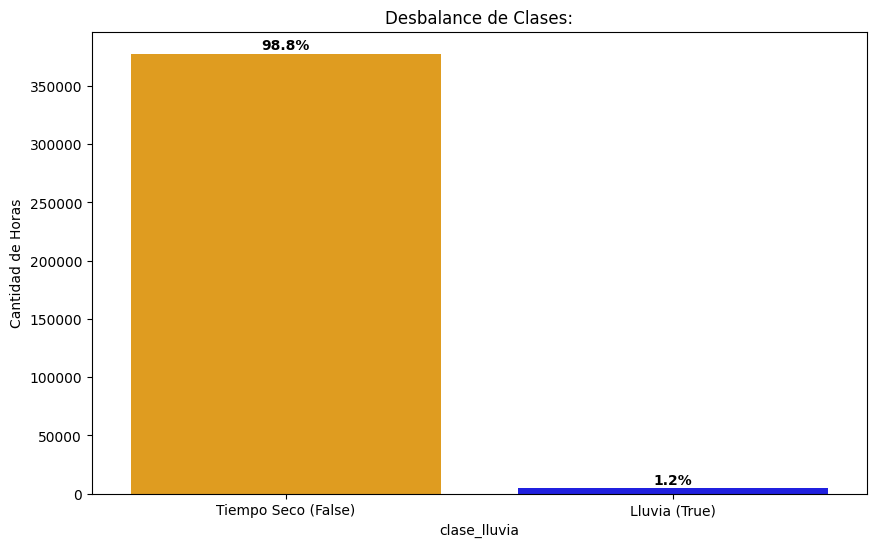

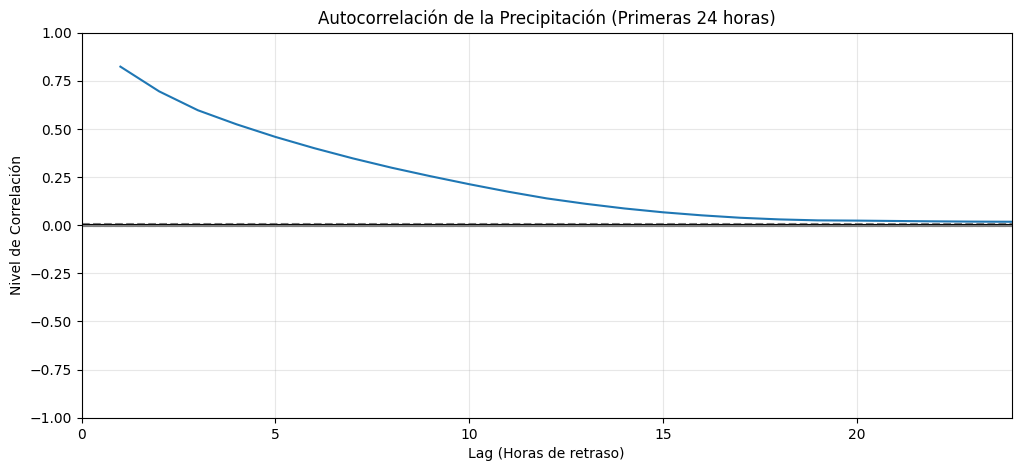

In [12]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

# -------------------------------------------------------------------------
# 1. CARGA DESDE EL ARCHIVO LIMPIO
# -------------------------------------------------------------------------
archivo = 'est_19_limpio.csv'

try:
    # Cargamos el CSV. Asumimos que la columna de tiempo se llama 'datetime'
    # (según tu clase anterior). Si se llama diferente, ajusta la lista parse_dates.
    df_fisico = pd.read_csv(archivo, parse_dates=['datetime'], index_col='datetime')
    print(f"Archivo '{archivo}' cargado correctamente.")
except ValueError:
    # Si falla el índice, intentamos cargarlo sin índice y luego buscar la columna
    df_fisico = pd.read_csv(archivo)
    if 'datetime' in df_fisico.columns:
        df_fisico['datetime'] = pd.to_datetime(df_fisico['datetime'])
        df_fisico = df_fisico.set_index('datetime').sort_index()
    print(f"Archivo cargado y re-indexado. Filas: {len(df_fisico)}")

# Aseguramos que 'precipitacion_real' sea numérica (por si se guardó como texto)
df_fisico['precipitacion_real'] = pd.to_numeric(df_fisico['precipitacion_real'], errors='coerce')

# -------------------------------------------------------------------------
# 2. ANÁLISIS DE DESBALANCE (Clases: Lluvia vs No Lluvia)
# -------------------------------------------------------------------------
plt.figure(figsize=(10, 6))

# Umbral: 0.2 mm (estándar para considerar que llovió)
df_fisico['clase_lluvia'] = df_fisico['precipitacion_real'] > 0.2
conteo = df_fisico['clase_lluvia'].value_counts()

# Colores: Naranja (Seco), Azul (Lluvia)
ax = sns.barplot(x=conteo.index, y=conteo.values, palette=['orange', 'blue'])

plt.xticks([0, 1], ['Tiempo Seco (False)', 'Lluvia (True)'])
plt.ylabel('Cantidad de Horas')
plt.title('Desbalance de Clases:')

# Etiquetas de porcentaje
total = len(df_fisico)
for i, v in enumerate(conteo.values):
    pct = (v / total) * 100
    plt.text(i, v + (total*0.01), f'{pct:.1f}%', ha='center', fontweight='bold')

plt.show()

# -------------------------------------------------------------------------
# 3. AUTOCORRELACIÓN (Memoria de la Lluvia)
# -------------------------------------------------------------------------
plt.figure(figsize=(12, 5))

# Filtramos nulos para evitar errores en el gráfico
serie_lluvia = df_fisico['precipitacion_real'].dropna()

# Graficamos la autocorrelación
autocorrelation_plot(serie_lluvia)

# Zoom a las primeras 24 horas (lo más relevante para predicción)
plt.xlim(0, 24)
plt.title('Autocorrelación de la Precipitación (Primeras 24 horas)')
plt.xlabel('Lag (Horas de retraso)')
plt.ylabel('Nivel de Correlación')
plt.grid(True, alpha=0.3)
plt.show()